## AIS Anomaly Detection

In [33]:
# from IPython.display import Image, HTML
import os
import numpy as np
import math
import pandas as pd
import datetime
from glob import glob
import geopy.distance
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")           # Suppress Warning

### Global Variables

In [10]:
WorkingFolder = "/Users/cv0361/Desktop/TechChallenge/Data/csv/ConsolidatedAIS/"
OutputDir = WorkingFolder
MAX_CLUSTER = 5

### Load Broadcast Data

In [13]:
Broadcast = pd.read_csv(WorkingFolder + "Broadcast_2014.csv", sep=",", parse_dates=['date_time'])
Broadcast.head()

,mmsi_id,date_time,lat,lon,speed_over_ground,course_over_ground,voyage_id,heading,status
0,366025993,2013-12-31 23:57:44,47.581332,-122.361145,0.0,39.599998,1,511,0
1,367160890,2013-12-31 23:57:44,45.835737,-123.990592,6.7,355.399990,2,359,15
2,366490600,2013-12-31 23:57:44,47.631067,-122.382117,0.0,192.100010,3,180,7
3,338000406,2013-12-31 23:57:44,48.123443,-123.444115,0.0,14.200000,4,511,0
4,367840001,2013-12-31 23:57:44,48.121267,-122.726412,11.4,55.400002,5,57,0


In [14]:
print("Raw Count:", Broadcast.shape[0])

Raw Count: 21517764


In [15]:
# Make sure voyage id is not null
Broadcast['voyage_id'] = Broadcast['voyage_id'].fillna(0)
Broadcast = Broadcast.astype({"voyage_id": int})           # cast type to int

### Clustering via K-means
* https://github.com/JosephMagiya/Clustering-GPS-Co-ordinates--Forming-Regions./blob/master/Clustering-GPS-Co-ordinates--Forming-Regions.ipynb

In [27]:
# Identify Anomaly
for mmsi in Broadcast.mmsi_id.unique():
    
    mmsi = 366985110           #**************** Test data
    
    df = Broadcast.loc[Broadcast.mmsi_id==mmsi, ['date_time', 'lat', 'lon']] 
    Anomaly_THRESHOLD = math.ceil(df.shape[0]/15000)     # dynamically determine the anomaly threshold based on total pings
    
#     # **** for testing - Fudge some anomaly
#     df.loc[df.date_time=='2017-01-01 00:06:50', 'lat'] = 70.25
#     # *************************************

    X = df[['lat', 'lon']]
    
    kmeans = KMeans(n_clusters=MAX_CLUSTER, init='k-means++')
    kmeans.fit(X)                                   # Compute k-means clustering. 
    df['cluster_label'] = kmeans.predict(X)         # Labels of each point
    centers = kmeans.cluster_centers_               # Coordinates of cluster centers.
    
    # Cluster, ping counts
    PingCluster = df.groupby('cluster_label')['date_time'].count().reset_index()
    
    # Identify Anomaly in coordinate, if any
    AnomalyCluster = PingCluster.loc[PingCluster.date_time <= Anomaly_THRESHOLD, 'cluster_label'].values
    
    # Locate anomaly data points
    AnaCoordinate = df.loc[df.cluster_label.isin(AnomalyCluster)]
    
    if AnaCoordinate.shape[0] > 0:
        print("MMSI: {} \tPings: {} \tThreshold: {}".format(mmsi, df.shape[0], Anomaly_THRESHOLD))
        
        for index, row in AnaCoordinate.sort_values('cluster_label').iterrows():
            print("\tCluster:{} ({}, {}) {}".format(row.cluster_label, row.lat, row.lon, row.date_time))
    
        break
    
    break

MMSI: 366985110 	Pings: 33766 	Threshold: 3
	Cluster:1 (46.199397999999995, -123.93110700000001) 2014-01-21 16:28:50
	Cluster:1 (46.197055, -123.924967) 2014-01-21 16:29:50
	Cluster:1 (46.19781500000001, -123.92719199999999) 2014-01-21 16:30:52
	Cluster:3 (46.202828000000004, -123.939575) 2014-01-21 16:26:45
	Cluster:3 (46.201563, -123.937022) 2014-01-21 16:27:46
	Cluster:3 (46.20244, -123.934802) 2014-01-21 16:31:51
	Cluster:4 (46.211372, -123.948995) 2014-01-21 16:33:59
	Cluster:4 (46.211338, -123.95091799999999) 2014-01-21 16:34:59
	Cluster:4 (46.20995300000001, -123.95029299999999) 2014-01-21 16:36:00


In [28]:
df.head()

,date_time,lat,lon,cluster_label
64,2013-12-31 23:57:44,46.204338,-123.950212,0
823,2014-01-01 00:00:44,46.204383,-123.950225,0
1439,2014-01-01 00:01:54,46.204358,-123.950217,0
1946,2014-01-01 00:02:53,46.204418,-123.950237,0
2667,2014-01-01 00:04:24,46.204395,-123.950195,0


In [49]:
# Locate and agg data for a selected cluster
Select_Cluster = 0

stat = df.loc[df.cluster_label==Select_Cluster].agg(['count', 'max', 'min'])   
stat

,date_time,lat,lon,cluster_label
count,33751,33751.000000,33751.000000,33751
max,2014-01-31 23:59:20,46.206548,-123.948275,0
min,2013-12-31 23:57:44,46.204057,-123.950482,0


In [30]:
int(stat.lat[0]), stat.lat[1], stat.lat[2]

(33751, 46.206548, 46.204057)

In [31]:
stat.lon[1], stat.lon[2]

(-123.948275, -123.95048200000001)

In [32]:
centers

array([[  46.20439842, -123.95021678],
       [  46.19808933, -123.92775533],
       [  46.20606483, -123.9440315 ],
       [  46.202277  , -123.937133  ],
       [  46.21088767, -123.95006867]])

In [38]:
lat1 = 54.47611
lon1 = -167.27802
lat2 = 53.47611
lon2 = -160.27802

geopy.distance.distance((lat1, lon1), (lat2, lon2)).mi

293.51584998493763

In [48]:
def Calc_Centroid_Radius(center_latlon, lat_max, lat_min, lon_max, lon_min):
    dist = list()
    
    # Center distance to the outer most coordinates
    dist.append(geopy.distance.distance((center_latlon[0], center_latlon[1]), (lat_max, lon_max)).mi)
    dist.append(geopy.distance.distance((center_latlon[0], center_latlon[1]), (lat_max, lon_min)).mi)
    dist.append(geopy.distance.distance((center_latlon[0], center_latlon[1]), (lat_min, lon_max)).mi)
    dist.append(geopy.distance.distance((center_latlon[0], center_latlon[1]), (lat_min, lon_min)).mi)
    
    print(dist)
    
    return max(dist)

Calc_Centroid_Radius(centers[0], stat.lat[1], stat.lat[2], stat.lon[1], stat.lon[2])

[0.1752539194492259, 0.14901261792610832, 0.09605943213489654, 0.02679279582095836]


0.1752539194492259

In [280]:
# Broadcast_Zone03_2017_01
# =========================
# 367094420      ARCTIC MARINER 	 type: 1001 - Fishing, 31x9.28       lots of points   multiple trips, same route
# 367565680      ADAMANT             type: 1001 - Fishing, 18x8          lots of points   ?
# 367373760      NORTH SEA           type: 1001 - Fishing, 37x10                          ?
# 440102000      TORAH               type: 1004 - Freight, 115.8x16.62   lots of points   weird
# 636014222      Zim Rotter          type: 1004 - Freight, 349x45.73                      Going some where
# 367322830      GYRFALCON           type: 1025 - Towing, 30.63x10.4     lots of points   weird behavior

# Broadcast_Zone10_2014_01
# =========================
# 316500126                          type: 31 - TugTow,     15x5        irregular pattern towing
# 367528210                          type: 31 - TugTow,     33x13       irregular pattern towing
# 316881510                          type: 52 - TugTow,     28x13       irregular pattern towing
# 366025993                          type: 52 - TugTow,     21x7        pattern?
# 538001471                          type: 70 - Cargo,     302x44      path pattern
# 538284070                          type: 70 - Cargo,     184x31      path pattern
# 229560200                          type: 70 - Cargo,     350x42      path pattern
# 235733603                          type: 80 - Tanker,    183x32      path pattern
# 538007477                          type: 0 - Tanker?,    170x27      Going some where
# 366089092                          type: 0, 30x6        Infrequent ping per trip


mmsi = 366985110 
voyage_id = 0

df = Broadcast.loc[Broadcast.mmsi_id==mmsi, ['date_time', 'lat', 'lon', 'speed_over_ground', 'voyage_id']]  # & (Broadcast.voyage_id.isnull()
df.rename(columns={'lat':'latitude', 'lon':'longitude'}, inplace=True)

df['PingDate'] = df['date_time'].dt.date
df['PingHour'] = df['date_time'].dt.hour

df.head()

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour
64,2013-12-31 23:57:44,46.204338,-123.950212,0.0,66,2013-12-31,23
823,2014-01-01 00:00:44,46.204383,-123.950225,0.0,66,2014-01-01,0
1439,2014-01-01 00:01:54,46.204358,-123.950217,0.0,66,2014-01-01,0
1946,2014-01-01 00:02:53,46.204418,-123.950237,0.0,66,2014-01-01,0
2667,2014-01-01 00:04:24,46.204395,-123.950195,0.0,66,2014-01-01,0


In [281]:
# # Fudge some anomaly
# df.loc[df.date_time=='2017-01-10 01:12:31', 'latitude'] = 70.25
# df.loc[df.date_time=='2014-01-01 00:03:06', 'longitude'] = -100.123
# df.head()

In [282]:
df.shape

(33766, 7)

In [283]:
# Get Unique voyage Id
df.voyage_id.unique()

array([66])

In [284]:
# # Select 1 voyage
# df = df.loc[df.voyage_id==1]
# df.shape

In [285]:
# df.describe()
df.agg(['count', 'max', 'min', 'mean', 'median', 'std', 'nunique'])   

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour
count,33766,33766.000000,33766.000000,33766.000000,33766.0,33766,33766.000000
max,2014-01-31 23:59:20,46.211372,-123.924967,25.700001,66.0,2014-01-31,23.000000
min,2013-12-31 23:57:44,46.197055,-123.950918,0.000000,66.0,2013-12-31,0.000000
mean,2014-01-15 03:12:57.018539264,46.204399,-123.950213,0.023023,66.0,NaN,11.525854
nunique,33766,212.000000,192.000000,28.000000,1.0,30,24.000000
median,NaN,46.204398,-123.950217,0.000000,66.0,NaN,12.000000
std,NaN,0.000098,0.000263,0.318203,0.0,NaN,6.961592


In [286]:
mygroup = df.groupby(['voyage_id', 'PingDate', 'PingHour'])
sampling = mygroup['latitude', 'longitude', 'speed_over_ground'].mean()  
sampling['PingCount'] = mygroup['latitude'].count()
sampling.reset_index(inplace=True)
sampling.head()

,voyage_id,PingDate,PingHour,latitude,longitude,speed_over_ground,PingCount
0,66,2013-12-31,23,46.204338,-123.950212,0.000000,1
1,66,2014-01-01,0,46.204382,-123.950204,0.025490,51
2,66,2014-01-01,1,46.204384,-123.950236,0.002083,48
3,66,2014-01-01,2,46.204389,-123.950230,0.003922,51
4,66,2014-01-01,3,46.204414,-123.950230,0.000000,52


In [287]:
sampling['Text'] = sampling.apply(lambda x: "{}:{}-V:{} - SOG: {} - Count: {} ({}, {})".format(x.PingDate, x.PingHour, x.voyage_id, round(x.speed_over_ground, 1), x.PingCount, round(x.latitude, 3), round(x.longitude, 3)), axis=1)   
sampling.head()

,voyage_id,PingDate,PingHour,latitude,longitude,speed_over_ground,PingCount,Text
0,66,2013-12-31,23,46.204338,-123.950212,0.000000,1,2013-12-31:23-V:66 - SOG: 0.0 - Count: 1 (46.2...
1,66,2014-01-01,0,46.204382,-123.950204,0.025490,51,2014-01-01:0-V:66 - SOG: 0.0 - Count: 51 (46.2...
2,66,2014-01-01,1,46.204384,-123.950236,0.002083,48,2014-01-01:1-V:66 - SOG: 0.0 - Count: 48 (46.2...
3,66,2014-01-01,2,46.204389,-123.950230,0.003922,51,2014-01-01:2-V:66 - SOG: 0.0 - Count: 51 (46.2...
4,66,2014-01-01,3,46.204414,-123.950230,0.000000,52,2014-01-01:3-V:66 - SOG: 0.0 - Count: 52 (46.2...


In [288]:
sampling.shape

(642, 8)

In [289]:
# sampling.to_csv(OutputDir + 'sampling_366089092.csv', index=None, header = True)

In [290]:
# Cluster the Sampling data instead; faster but will hide the individual anomaly
# df = sampling

In [291]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

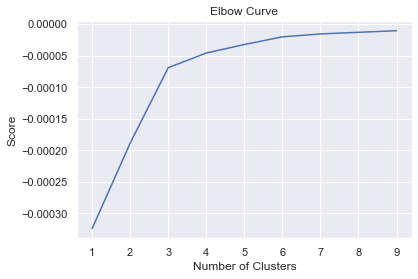

In [292]:
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [293]:
X = df[['latitude', 'longitude']]

kmeans = KMeans(n_clusters=MAX_CLUSTER, init='k-means++')

kmeans.fit(X)                                   # Compute k-means clustering. # Compute k-means clustering.
df['cluster_label'] = kmeans.predict(X)         # Labels of each point
centers = kmeans.cluster_centers_               # Coordinates of cluster centers.

df.head(3)

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour,cluster_label
64,2013-12-31 23:57:44,46.204338,-123.950212,0.0,66,2013-12-31,23,0
823,2014-01-01 00:00:44,46.204383,-123.950225,0.0,66,2014-01-01,0,0
1439,2014-01-01 00:01:54,46.204358,-123.950217,0.0,66,2014-01-01,0,0


In [294]:
centers

array([[  46.20439842, -123.95021678],
       [  46.19808933, -123.92775533],
       [  46.2026595 , -123.938226  ],
       [  46.2065164 , -123.9445368 ],
       [  46.21088767, -123.95006867]])

In [295]:
# Distribution Summary for all clusters - Cluster, ping counts
PingCluster = df.groupby('cluster_label')['date_time'].count().reset_index()
PingCluster.rename(columns={'date_time':'PingCount'}, inplace=True)
PingCluster.sort_values('PingCount')

,cluster_label,PingCount
1,1,3
4,4,3
2,2,4
3,3,5
0,0,33751


In [296]:
# Identify Anomaly in coordinate, if any
Anomaly_THRESHOLD = 10

AnomalyCluster = PingCluster.loc[PingCluster.PingCount < Anomaly_THRESHOLD, 'cluster_label'].values
df.loc[df.cluster_label.isin(AnomalyCluster)].head()

,date_time,latitude,longitude,speed_over_ground,voyage_id,PingDate,PingHour,cluster_label
14629379,2014-01-21 16:23:43,46.205508,-123.945390,6.4,66,2014-01-21,16,3
14629907,2014-01-21 16:24:44,46.204857,-123.943240,5.8,66,2014-01-21,16,3
14630418,2014-01-21 16:25:44,46.203807,-123.941505,5.6,66,2014-01-21,16,2
14630927,2014-01-21 16:26:45,46.202828,-123.939575,6.7,66,2014-01-21,16,2
14631435,2014-01-21 16:27:46,46.201563,-123.937022,8.0,66,2014-01-21,16,2


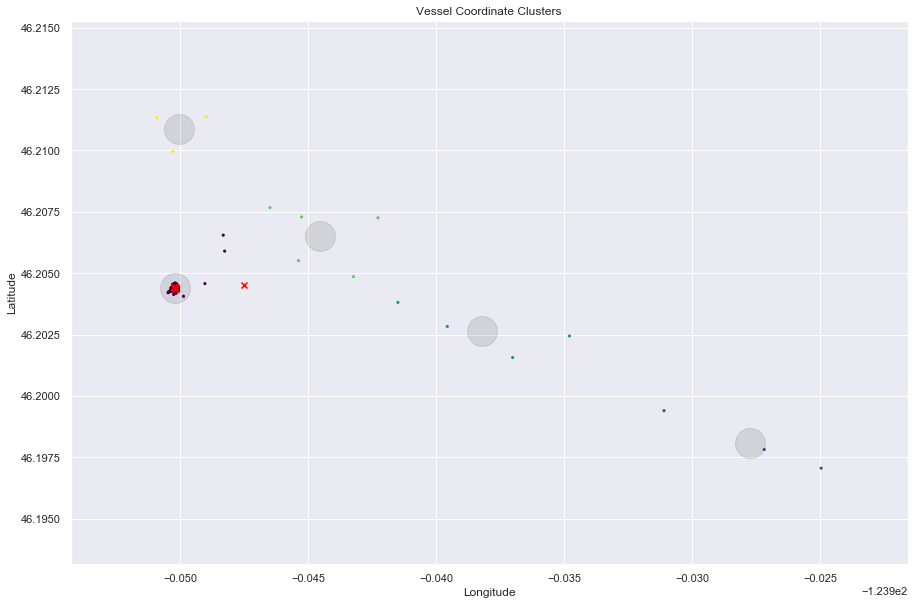

In [297]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

ax.scatter(df.longitude, df.latitude, s=10, lw=0, c=df['cluster_label'], cmap='viridis', alpha=1)

ax.scatter(sampling.longitude, sampling.latitude, marker='x', color='red')

ax.scatter(centers[:, 1], centers[:, 0], c='black', s=900, alpha=0.1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Vessel Coordinate Clusters')
plt.show()

In [298]:
X = sampling  #.head()

# ********** Fudge data for testing
# a = X[['latitude', 'longitude']].values.tolist()
# a.append([70.25, -122.338602])
# a.append([47.601398, -100.123])
# **********************************

MapCoordinates = X[['latitude', 'longitude']].values
PopupText = X.Text.values 

mapit = folium.Map(location=MapCoordinates[0], zoom_start=8)

for index in range(0, len(MapCoordinates)):
    folium.Marker(MapCoordinates[index], popup=PopupText[index]).add_to(mapit)  #, popup=PopupText[index]
    
mapit

### Sample Folium
* https://github.com/python-visualization/folium
* https://github.com/collinreinking/longitude_latitude_dot_plots_in_python_with_folium/blob/master/MapsTutorials.ipynb
* https://georgetsilva.github.io/posts/mapping-points-with-folium/

In [191]:
# import folium

# latlon = [(51.249443914705175, -0.13878830247011467), (51.249443914705175, -0.19), (51.249768239976866, -2.8610415615063034)]
# text = ['point1','point2','point3']

# mapit = folium.Map(location=[51.25, -1.2], zoom_start=9)

# for point in range(0, len(latlon)):
#     folium.Marker(latlon[point], popup=text[point]).add_to(mapit)

# # mapit.save( 'map.html')
# mapit

### Sample HDBSCAN
* https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html

In [26]:
from sklearn.datasets import make_blobs
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
blobs, labels = make_blobs(n_samples=2000, n_features=10)

In [8]:
pd.DataFrame(blobs).head()

,0,1,2,3,4,5,6,7,8,9
0,-1.264875,-8.260352,-7.672387,-4.457326,-2.654197,4.046740,4.732487,-8.031294,-3.358178,0.746357
1,-4.789295,5.347213,-9.076223,-2.658427,7.980381,6.582558,-2.511977,9.363582,9.516691,-6.797194
2,-8.840059,4.799937,-8.509396,1.783674,5.945335,-6.128442,-8.588533,-1.142080,8.091949,9.063377
3,-6.527711,5.229888,-8.250775,-0.308170,6.792324,5.278408,-1.254370,5.681781,9.835620,-6.410695
4,-8.316694,6.439864,-9.477828,-0.442857,4.329686,-4.317371,-8.836133,-2.024001,9.477133,8.406125


In [22]:
blobs.shape

(2000, 10)

In [23]:
blobs

array([[ -1.26487527,  -8.2603524 ,  -7.67238674, ...,  -8.03129446,
         -3.35817837,   0.74635706],
       [ -4.78929506,   5.34721314,  -9.0762227 , ...,   9.36358247,
          9.51669117,  -6.79719369],
       [ -8.84005935,   4.79993719,  -8.50939632, ...,  -1.14208   ,
          8.09194909,   9.06337698],
       ...,
       [ -1.48204497,  -7.86863968,  -8.58340059, ...,  -9.08749093,
         -2.90563069,  -1.05112635],
       [ -1.86398912,  -9.04289069,  -8.43069477, ..., -10.74356022,
         -2.72570248,   0.7149232 ],
       [ -3.82640572,   5.8166833 ,  -8.18621666, ...,   6.85105027,
          9.21200197,  -7.92391158]])

In [34]:
data = blobs.T[:,0:2]

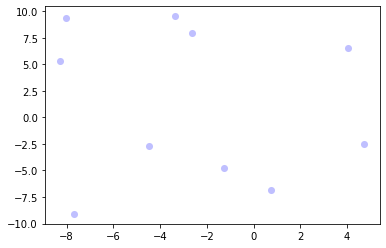

In [35]:
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

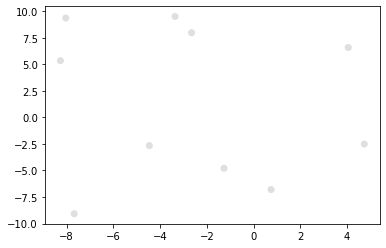

In [36]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [37]:
clusterer.condensed_tree_

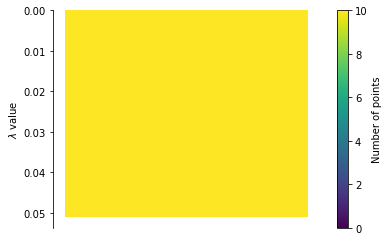

In [38]:
clusterer.condensed_tree_.plot()

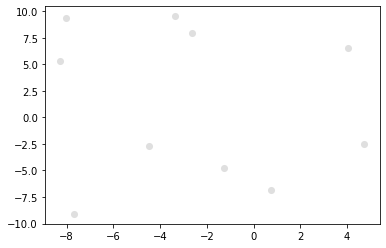

In [39]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

In [32]:
blobs.T[:,0:2].shape

(10, 2)

In [10]:
clusterer = hdbscan.HDBSCAN()

In [11]:
clusterer.fit(blobs)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [24]:
len(clusterer.labels_)

2000

In [12]:
clusterer.labels_

array([0, 1, 2, ..., 0, 0, 1])

In [13]:
clusterer.labels_.max()

2

In [14]:
clusterer.probabilities_

array([0.65203928, 0.80439755, 0.82601858, ..., 1.        , 0.62995029,
       0.62921136])

In [15]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')
clusterer.fit(blobs)
clusterer.labels_

array([0, 1, 2, ..., 0, 0, 1])

In [16]:
hdbscan.dist_metrics.METRIC_MAPPING

{'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'rogerst

In [17]:
from sklearn.metrics.pairwise import pairwise_distances

In [18]:
distance_matrix = pairwise_distances(blobs)

In [19]:
distance_matrix

array([[ 0.        , 30.00083681, 29.50051889, ...,  3.55500992,
         4.3568916 , 29.92376286],
       [30.00083681,  0.        , 24.56326019, ..., 29.60063764,
        32.27173609,  5.39005198],
       [29.50051889, 24.56326019,  0.        , ..., 30.14754856,
        30.84141333, 23.7567574 ],
       ...,
       [ 3.55500992, 29.60063764, 30.14754856, ...,  0.        ,
         4.06465649, 29.23320791],
       [ 4.3568916 , 32.27173609, 30.84141333, ...,  4.06465649,
         0.        , 31.76605252],
       [29.92376286,  5.39005198, 23.7567574 , ..., 29.23320791,
        31.76605252,  0.        ]])

In [20]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(distance_matrix)
clusterer.labels_

array([0, 2, 1, ..., 0, 0, 2])